In [21]:
# Przygotowanie środowiska
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# Globalne zmienne
r = 0.04  # stopa zwrotu z IKE
inflacja = 0.025
belka = 0.19
podatek_od_prywatyzacji = 0.15
stawka_pit = 0.17  # na emeryturze
waloryzacja_emerytur = inflacja + 0.2*0.04  # oficjalna inflacja + 20% realnego wzrostu gospodarczego

# Zmienna dla konkretnego przypadku
prognozowana_emerytura_brutto = 3000
skladka_zdrowotna = prognozowana_emerytura_brutto * 0.09
zaliczka_pit = prognozowana_emerytura_brutto * stawka_pit - 556.02/12 - prognozowana_emerytura_brutto * 0.0775
prognozowana_emerytura_netto = prognozowana_emerytura_brutto - skladka_zdrowotna - zaliczka_pit
efektywna_stawka_opodatkowania = 1 - prognozowana_emerytura_netto / prognozowana_emerytura_brutto

# TODO zmienny efektywny pit - (inflacja rośnie, to podatek się zmienia)
ofe = 11500
kobieta = 0
do_emerytury = 13
lat_na_emeryturze_wg_zus = 18+5*kobieta  # https://www.money.pl/emerytury/emerytury-gus-ma-jednoczesnie-dobra-i-zla-wiadomosc-dane-dotycza-sredniej-dlugosci-zycia-6363469538014849a.html
oczekiwana_dlugosc_zycia = 100  # jesli dozyje do emerytury  # https://stat.gov.pl/obszary-tematyczne/ludnosc/trwanie-zycia/trwanie-zycia-w-2018-r-,2,13.html
oczekiwana_liczba_lat_na_emeryturze = oczekiwana_dlugosc_zycia - 65 + 5*kobieta

Text(0.5, 1.0, 'Stopy waloryzacji kapitału zgromadzonego w ZUS')

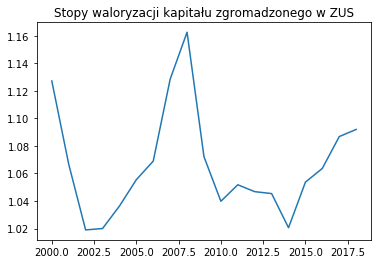

In [54]:
# Historyczne wartości waloryzacji kapitału zgromadzonego w ZUS
hist_waloryzacja = [1.1272, 1.0668, 1.0190, 1.0200, 1.0363, 1.0555, 1.0690, 1.1285, 1.1626, 1.0722, 1.0398, 1.0518, 1.0468, 1.0454, 1.0206, 1.0537, 1.0637, 1.0868, 1.0920]
mean_hist_waloryzacja = np.mean(hist_waloryzacja)
q40_hist_waloryzacja = np.quantile(hist_waloryzacja, 0.4)
avg_geom_hist_waloryzacja = np.power(np.prod(hist_waloryzacja), 1/len(hist_waloryzacja))

plt.plot([int(x) for x in range(2000, 2019)], hist_waloryzacja)
plt.title('Stopy waloryzacji kapitału zgromadzonego w ZUS')

In [55]:
# Wariant 1: Prywatyzacja środków
# Etap 1: Do emerytury

# w 1. roku sprywatyzowania OFE wartość kapitału topnieje o 7.5%, reszta pracuje na inwestycji w ramach IKE bez podatku belki
# w 2. roku wartość kapitału topnieje o kolejne 7.5%, ale pracuje na inwestycji w ramach IKE bez podatku Belki
# w 3. i każdym kolejnym roku do emerytury wartość kapitału rośnie o oczekiwaną stopę zwrotu, bez podatku Belki
NPV_IKE = ofe * (1 - podatek_od_prywatyzacji/2) * (1+r) * (1 - podatek_od_prywatyzacji/2) * (1+r) * np.power((1+r), do_emerytury-2)

# W momencie wypłaty środków z IKE ich wartość nominalna jest wysoka, jednak wartość realna zjadana jest przez inflację, toteż wartość nominalna > realna. Deflator:
NPV_IKE = NPV_IKE / np.power((1+inflacja), do_emerytury)
print("Zgromadzony kapitał na IKE w momencie przejścia na emeryturę wynosi %d PLN na dzisiejsze pieniądze (po opodatkowaniu i w cenach z dzisiaj)" % NPV_IKE)

Zgromadzony kapitał na IKE w momencie przejścia na emeryturę wynosi 11885 PLN na dzisiejsze pieniądze (po opodatkowaniu i w cenach z dzisiaj)


In [56]:
# Etap 2: Po emeryturze
projekcja_IKE = pd.Series(range(1, oczekiwana_liczba_lat_na_emeryturze + 1), name='rok_emerytury').to_frame()

NPV_IKE_dyn = NPV_IKE
NPV_IKE_list = list()
kapital_rok = list()

# Zakładamy, że na emeryturze kapitał pracuje nam na bezpiecznej lokacie (opodatkowanej podatkiem Belki)
for rok in range(oczekiwana_liczba_lat_na_emeryturze):
    # Kapitał wypłacamy sobie proporcjonalnie do pozostałych lat na emeryturze - np. pozostało nam (statystycznie) 5 lat, więc wypłacamy sobie 1/5 tego co zostało
    kapital_rok.append(NPV_IKE_dyn / (oczekiwana_liczba_lat_na_emeryturze - rok))
    # w międzyczasie, kapitał, który pozostał inwestujemy, ale zżera go nam też inflacja
    NPV_IKE_dyn = (NPV_IKE_dyn - NPV_IKE_dyn/(oczekiwana_liczba_lat_na_emeryturze - rok)) * (1 + r*(1-belka)) / (1+inflacja)
    NPV_IKE_list.append(NPV_IKE_dyn)
    
projekcja_IKE['NPV_IKE'] = NPV_IKE_list
projekcja_IKE['kapital_rok'] = kapital_rok
projekcja_IKE['IKE_dodatek_emerytura'] = round(projekcja_IKE['kapital_rok']/12, 2)

print("Efekt wybrania prywatyzacji:")
print("W pierwszym roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_IKE['IKE_dodatek_emerytura'].iloc[0]))
print("W {}. roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_IKE.shape[0], projekcja_IKE['IKE_dodatek_emerytura'].iloc[projekcja_IKE.shape[0]-1]))
print("\n")
print("Jeśli umrzemy wcześniej niż średnia, wtedy niewykorzystany kapitał jest dziedziczony")
print("Jeśli przeżyjemy dłużej niż średnia, po wyczerpaniu środków z IKE emerytura wraca do bazowej wielkości")
print("\n")
print("Szanse: wyższy zwrot z inwestycji, niższa inflacja, zmiana zasad pobierania podatku Belki na bardziej korzystne dla konsumentów")
print("Zagrożenia: Ponowna grabież środków tym razem z IKE, kiepskie inwestycje, wysoka inflacja, podwyżka podatku Belki")
projekcja_IKE

Efekt wybrania prywatyzacji:
W pierwszym roku emerytury zwiększy nam emeryturę o 28.3 PLN
W 35. roku emerytury zwiększy nam emeryturę o 36.14 PLN


Jeśli umrzemy wcześniej niż średnia, wtedy niewykorzystany kapitał jest dziedziczony
Jeśli przeżyjemy dłużej niż średnia, po wyczerpaniu środków z IKE emerytura wraca do bazowej wielkości


Szanse: wyższy zwrot z inwestycji, niższa inflacja, zmiana zasad pobierania podatku Belki na bardziej korzystne dla konsumentów
Zagrożenia: Ponowna grabież środków tym razem z IKE, kiepskie inwestycje, wysoka inflacja, podwyżka podatku Belki


,rok_emerytury,NPV_IKE,kapital_rok,IKE_dodatek_emerytura
0,1,11628.922328,339.575557,28.30
1,2,11368.381079,342.027127,28.50
2,3,11103.471752,344.496396,28.71
3,4,10834.144858,346.983492,28.92
4,5,10560.350418,349.488544,29.12
5,6,10282.037964,352.011681,29.33
6,7,9999.156529,354.553033,29.55
7,8,9711.654649,357.112733,29.76
8,9,9419.480352,359.690913,29.97
9,10,9122.581159,362.287706,30.19


In [57]:
# Wariant 2: Przeniesienie środków do ZUS
# Etap 1: Do emerytury

# Środki z OFE zostają przekazane do ZUS, gdzie korzystają z corocznej waloryzacji kapitału, która historycznie była wysoka
# Zeszłoroczna waloryzacja była wyższa niż średnia
# Do obliczeń założymy konserwatywnie nie średnią, ani nie medianę (jeszcze niższa), tylko 40 percentyl tej wielkości od 2000 roku.
# Stopa waloryzacji jest pochodną rozwoju gospodarczego, założenie 40 percentyla to założenie o łagodnym, acz długotrwałym spowolnieniu gospodarczym.
# To jak najbardziej realne założenie, nieco gorsze od tego co wszyscy się spodziewamy. Na zapas.

# Środki z OFE zapisane są na konto w ZUS, są waloryzowane co roku, aż do momentu przejścia na emeryturę.
# Ich realna wartość będzie nieco zmniejszona przez inflację, co też jest uwzględnione
NPV_ZUS = ofe * np.power(q40_hist_waloryzacja, do_emerytury) / np.power((1+inflacja), do_emerytury)

# Uwaga: od tego kapitału będzie trzeba zapłacić podatek
print("Zgromadzony kapitał na ZUS w momencie przejścia na emeryturę wynosi %d PLN na dzisiejsze pieniądze (przed opodatkowaniem)" % NPV_ZUS)

Zgromadzony kapitał na ZUS w momencie przejścia na emeryturę wynosi 16160 PLN na dzisiejsze pieniądze (przed opodatkowaniem)


In [58]:
# kontynuacja: co po emeryturze?
projekcja_ZUS = pd.Series(range(1, lat_na_emeryturze_wg_zus + 1), name='rok_emerytury').to_frame()

# Zakładamy, że na emeryturze kapitał już nie jest waloryzowany. Zamiast tego waloryzowana jest emerytura
# Waloryzacja emerytury historycznie była zauważalnie niższa niż waloryzacja kapitału, dlatego tutaj przyjmujemy znacznie mniejsze wartości
# Dobra wiadomość jest taka, że waloryzacja emerytury nie może być niższa niż stopa inflacji statystycznego gospodarstwa emerytów powiększona o chyba 20% wzrostu gospodarczego.

# Tutaj wracamy do wartości nominalnej, bo od niej liczy się podatek
NPV_ZUS_dyn = NPV_ZUS * np.power((1+inflacja), do_emerytury) 
NPV_ZUS_list = list()
kapital_rok = list()
for rok in range(lat_na_emeryturze_wg_zus):
    # Emerytura jest obliczona w taki sposób, że ZUS wypłaca nam nasz kapitał proporcjonalnie do pozostałych lat na emeryturze
    # tutaj używamy wartości nominalnych, by móc poprawnie wyliczyć efektywny PIT) A POTEM ponownie stosujemy deflator sprzed emerytury
    kapital_rok.append(NPV_ZUS_dyn / (lat_na_emeryturze_wg_zus - rok) * (1-efektywna_stawka_opodatkowania) / np.power((1+inflacja), do_emerytury))
    # w międzyczasie, kapitał, który pozostał inwestujemy, ale zżera go nam też inflacja
    NPV_ZUS_dyn = (NPV_ZUS_dyn - NPV_ZUS_dyn/(lat_na_emeryturze_wg_zus - rok)) * (1+waloryzacja_emerytur) / (1+inflacja)
    NPV_ZUS_list.append(NPV_ZUS_dyn)
    
projekcja_ZUS['NPV_ZUS'] = NPV_ZUS_list
projekcja_ZUS['kapital_rok'] = kapital_rok
projekcja_ZUS['ZUS_dodatek_emerytura'] = round(projekcja_ZUS['kapital_rok']/12, 2)

print("Efekt wybrania ZUSu:")
print("W pierwszym roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_ZUS['ZUS_dodatek_emerytura'].iloc[0]))
# print("W {}. roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_ZUS.shape[0], projekcja_ZUS['ZUS_dodatek_emerytura'].iloc[projekcja_ZUS.shape[0]-1]))
print("\n")
print("Jeśli umrzemy wcześniej, wtedy niewykorzystany kapitał nie jest dziedziczony")
print("Jeśli przeżyjemy dłużej, po wyczerpaniu środków emerytura dalej jest waloryzowana o stopę nieco wyższą niż inflacja")
print("\n")
print("Szanse: podwyższenie kwoty wolnej od podatku, obniżenie PIT, przeciętny lub dobry rozwój gospodarki Polski")
print("Zagrożenia: Ustawowe obniżenie emerytur, zawieszenie lub zmiana zasad waloryzacji kapitału, problemy z ZUS")

Efekt wybrania ZUSu:
W pierwszym roku emerytury zwiększy nam emeryturę o 62.32 PLN


Jeśli umrzemy wcześniej, wtedy niewykorzystany kapitał nie jest dziedziczony
Jeśli przeżyjemy dłużej, po wyczerpaniu środków emerytura dalej jest waloryzowana o stopę nieco wyższą niż inflacja


Szanse: podwyższenie kwoty wolnej od podatku, obniżenie PIT, przeciętny lub dobry rozwój gospodarki Polski
Zagrożenia: Ustawowe obniżenie emerytur, zawieszenie lub zmiana zasad waloryzacji kapitału, problemy z ZUS


In [59]:
projekcja_ZUS_przez_pryzmat_oczekiwanej_dlugosci_zycia = pd.Series(range(1, oczekiwana_liczba_lat_na_emeryturze + 1), name='rok_emerytury').to_frame()
empiryczna_waloryzacja = (projekcja_ZUS['ZUS_dodatek_emerytura'] / projekcja_ZUS['ZUS_dodatek_emerytura'].shift(1))[1:].mean()
ZUS_dodatek_emerytura = [np.round(projekcja_ZUS['ZUS_dodatek_emerytura'][0] * np.power(empiryczna_waloryzacja, x), 2) for x in range(oczekiwana_liczba_lat_na_emeryturze)]
projekcja_ZUS_przez_pryzmat_oczekiwanej_dlugosci_zycia['ZUS_dodatek_emerytura'] = ZUS_dodatek_emerytura
projekcja_ZUS_przez_pryzmat_oczekiwanej_dlugosci_zycia

,rok_emerytury,ZUS_dodatek_emerytura
0,1,62.32
1,2,62.81
2,3,63.30
3,4,63.79
4,5,64.29
5,6,64.79
6,7,65.29
7,8,65.80
8,9,66.32
9,10,66.83


(0, 83.803)

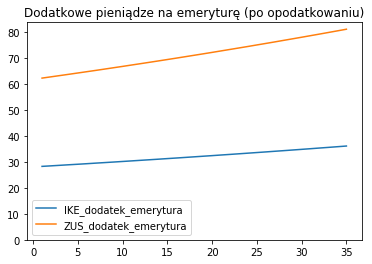

In [60]:
# Porównanie OFE->IKE vs. OFE->ZUS
plt.plot(projekcja_IKE['rok_emerytury'], projekcja_IKE['IKE_dodatek_emerytura'])
plt.plot(projekcja_ZUS_przez_pryzmat_oczekiwanej_dlugosci_zycia['rok_emerytury'], projekcja_ZUS_przez_pryzmat_oczekiwanej_dlugosci_zycia['ZUS_dodatek_emerytura'])
plt.title('Dodatkowe pieniądze na emeryturę (po opodatkowaniu)')
plt.legend()
plt.ylim(0)

In [61]:
# Podsumowanie
suma_dodatku_od_IKE = sum(projekcja_IKE['IKE_dodatek_emerytura'])*12
suma_dodatku_od_ZUS = sum(projekcja_ZUS_przez_pryzmat_oczekiwanej_dlugosci_zycia['ZUS_dodatek_emerytura'])*12

stosunek_ZUS_do_IKE = round((suma_dodatku_od_ZUS/suma_dodatku_od_IKE - 1)*100, 1)
stosunek_IKE_do_ZUS = round((suma_dodatku_od_IKE/suma_dodatku_od_ZUS - 1)*100, 1)

if suma_dodatku_od_ZUS > suma_dodatku_od_IKE:
    print("Wybranie ZUS zaowocuje średnio o {}% wyższym dodatkiem do emerytury".format(stosunek_ZUS_do_IKE))
elif suma_dodatku_od_ZUS < suma_dodatku_od_IKE:
    print("Wybranie IKE zaowocuje średnio o {}% wyższym dodatkiem do emerytury".format(stosunek_IKE_do_ZUS))
else:
    print("ganz egal")

Wybranie ZUS zaowocuje średnio o 122.5% wyższym dodatkiem do emerytury
